# predict

### setup

In [6]:
#configure for local mimic databse
exec(open("../configs/configure_mimic.py").read())
exec(open("my_functions.py").read())

#Global vars
CV=4


Configured for local MIMIC database:
	user = postgres
	dbname = mimic
	host = localhost
	schema_name = mimiciii
	query_schema = SET search_path to mimiciii;

Configured for my local MIMIC database (modified tables):
	my_username = postgres
	my_dbname = mimic
	host = localhost
	my_schema_name = my_mimic_db
	my_schema = SET search_path to my_mimic_db;


## load sets

In [7]:
import joblib
X_train = joblib.load(open(my_local_data_dir + 'X_train.joblib', 'rb'))
y_train = joblib.load(open(my_local_data_dir + 'y_train.joblib', 'rb'))
X_test = joblib.load(open(my_local_data_dir + 'X_test.joblib', 'rb'))
y_test = joblib.load(open(my_local_data_dir + 'y_test.joblib', 'rb'))
print(X_train.shape)
print(len(y_train))
print(np.sum(y_train))
print(X_test.shape)
print(len(y_test))
print(np.sum(y_test))

(35164, 294)
35164
1724
(8792, 294)
8792
431


## Handle imballanced data using SMOTE
(note decided not to use this, but keeping for demo purposes)

In [8]:
# from collections import Counter
# from imblearn.over_sampling import SMOTE
# counter = Counter(y_train)
# print(counter)
# pct=round(counter[1]/len(y_train), 3)*100
# print('starting positive rate = {}%'.format(pct))
# oversample = SMOTE()
# X_train_sm, y_train_sm = oversample.fit_resample(X_train, y_train)
# counter = Counter(y_train_sm)
# print(counter)
# pct=round(counter[1]/len(y_train_sm), 3)*100
# print('after SMOTE positive rate = {}%'.format(pct))

### set the SMOTE set as traning set

In [9]:
# X_train = X_train_sm
# y_train = y_train_sm
# X_train.shape

### train logistic regression

In [10]:
#logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
log_reg = LogisticRegressionCV(max_iter=1000,
#                                solver='liblinear',
                                 scoring='recall',
                               n_jobs=4)

#train
log_reg.fit(X_train, y_train)

LogisticRegressionCV(max_iter=1000, n_jobs=4, scoring='recall')

### logistic regression cross validation performance

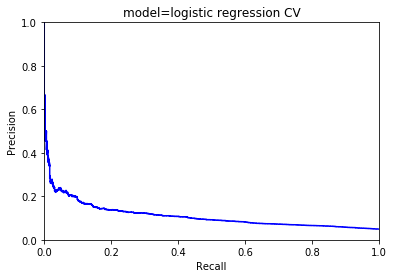

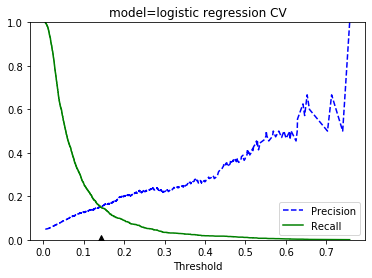

Confusion matrix for threshold = 0.14:
[[31977  1463]
 [ 1464   260]]
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     33440
           1       0.15      0.15      0.15      1724

    accuracy                           0.92     35164
   macro avg       0.55      0.55      0.55     35164
weighted avg       0.92      0.92      0.92     35164



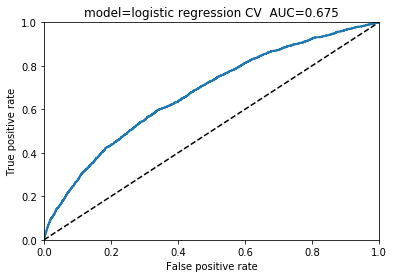

In [11]:
#logistic regression cross validation
probs_log_cv = cross_val_predict(log_reg, X_train, y_train, cv=CV, method="predict_proba", n_jobs=3)
scores_log_cv = probs_log_cv[:, 1]
log_perf_cv = get_model_performance('logistic regression CV', X_train, scores_log_cv, y_train, pos_label=1)

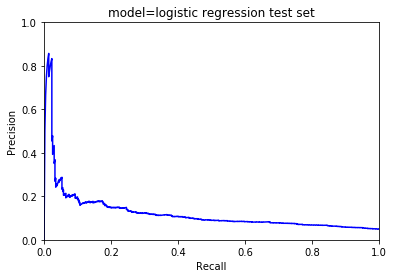

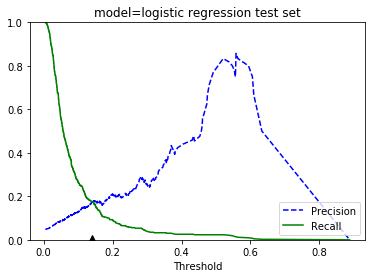

Confusion matrix for threshold = 0.14:
[[8006  355]
 [ 356   75]]
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      8361
           1       0.17      0.17      0.17       431

    accuracy                           0.92      8792
   macro avg       0.57      0.57      0.57      8792
weighted avg       0.92      0.92      0.92      8792



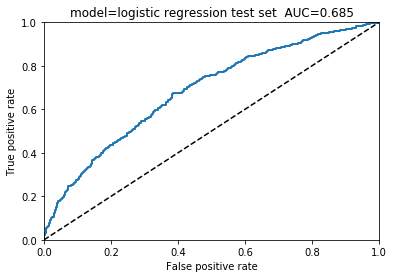

In [12]:
#performance on the test set
probs_test = log_reg.predict_proba(X_test)
scores_test = probs_test[:, 1]
test_perf = get_model_performance('logistic regression test set', X_test, scores_test, y_test, pos_label=1)

## Random forest

In [13]:
# ------- OPTIMIZE RF
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
RAND_SEED = 123
N_JOBS = 4
# use RandomizedSearchCV() to optimized Random forest hyperparameters
rf_clf = RandomForestClassifier(random_state=RAND_SEED,
                                n_estimators=200)

# choose parameter grid values
max_depth = [42, 45, 47, 50]
min_samples_split = [2]
min_samples_leaf = [1]
max_features = ["auto", "sqrt"]
# max_samples = [int(X_train.shape[0]*0.25),
#                int(X_train.shape[0]*0.5),
#                int(X_train.shape[0]*0.75),
#                int(X_train.shape[0])]

# make grid dict
random_grid = {'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_features': max_features}


# ### run random search
print('Random grid:')
print(random_grid)
rf_search = RandomizedSearchCV(estimator=rf_clf,
                               param_distributions=random_grid,
                               n_iter=100,
                               scoring='recall',
                               cv=4,
                               verbose=2,
                               random_state=RAND_SEED,
                               n_jobs=N_JOBS)
rf_search.fit(X_train, y_train)
best_params = rf_search.best_params_
print(rf_search.best_params_)

Random grid:
{'max_depth': [42, 45, 47, 50], 'min_samples_split': [2], 'min_samples_leaf': [1], 'max_features': ['auto', 'sqrt']}
Fitting 4 folds for each of 8 candidates, totalling 32 fits


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:282: UserWarning: The total space of parameters 8 is smaller than n_iter=100. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  32 out of  32 | elapsed:  2.1min finished


{'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 45}


In [14]:
best_params = {'min_samples_split': 2,
               'min_samples_leaf': 1,
               'max_features': 'auto',
               'max_depth': 45}

In [15]:
#set up optimized rf model based on from best_params above
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
print(best_params)
rf_opt = RandomForestClassifier(n_jobs=N_JOBS,
                                n_estimators=1000,
                                min_samples_split = best_params['min_samples_split'],
                                min_samples_leaf = best_params['min_samples_leaf'],
                                max_depth = best_params['max_depth'],
                                bootstrap = True,
                               random_state=RAND_SEED)

#train
rf_opt.fit(X_train, y_train)

{'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 45}


RandomForestClassifier(max_depth=45, n_estimators=1000, n_jobs=4,
                       random_state=123)

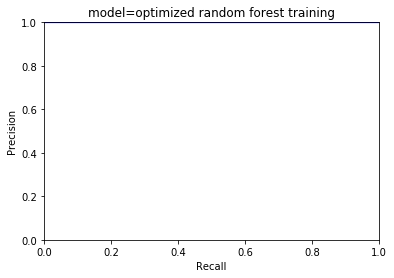

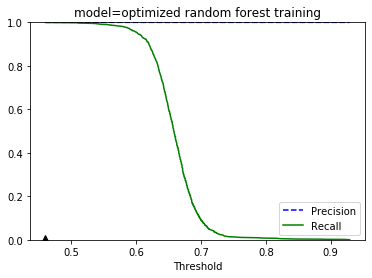

Confusion matrix for threshold = 0.46:
[[33440     0]
 [    1  1723]]
Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     33440
           1       1.00      1.00      1.00      1724

    accuracy                           1.00     35164
   macro avg       1.00      1.00      1.00     35164
weighted avg       1.00      1.00      1.00     35164



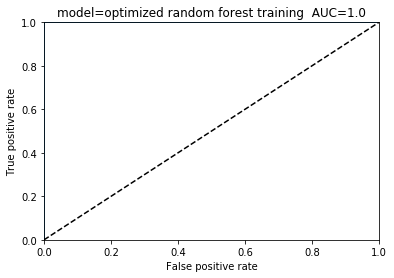

In [16]:
#optimized model performance on training set
scores_opt = rf_opt.predict_proba(X_train)[:, 1]
opt_perf = get_model_performance('optimized random forest training', X_train, scores_opt, y_train, pos_label=1)

### random forest cross validation performance

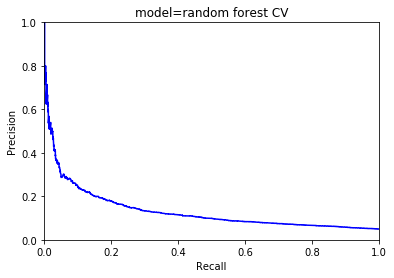

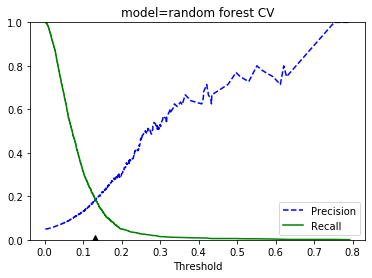

Confusion matrix for threshold = 0.13:
[[32038  1402]
 [ 1407   317]]
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     33440
           1       0.18      0.18      0.18      1724

    accuracy                           0.92     35164
   macro avg       0.57      0.57      0.57     35164
weighted avg       0.92      0.92      0.92     35164



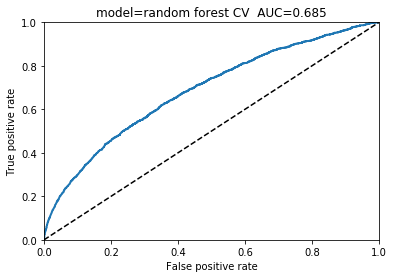

0.685


In [17]:
#logistic regression cross validation
rf_opt_cv = RandomForestClassifier(n_jobs=N_JOBS,
                                n_estimators=1000,
                                min_samples_split = best_params['min_samples_split'],
                                min_samples_leaf = best_params['min_samples_leaf'],
                                max_depth = best_params['max_depth'],
                                bootstrap = True,
                               random_state=RAND_SEED)
probs_rf_cv = cross_val_predict(rf_opt_cv, X_train, y_train, cv=CV, method="predict_proba", n_jobs=3)
scores_rf_cv = probs_rf_cv[:, 1]
rf_perf_cv = get_model_performance('random forest CV', X_train, scores_rf_cv, y_train, pos_label=1)
print(rf_perf_cv['auc'])

## Build learning curve

In [29]:
from sklearn.model_selection import learning_curve
from sklearn.pipeline import make_pipeline
pipe_lr = make_pipeline(RandomForestClassifier(n_estimators=500,
                                               min_samples_split=best_params['min_samples_split'],
                                               min_samples_leaf=best_params['min_samples_leaf'],
                                               max_depth=best_params['max_depth'],
                                               bootstrap=True,
                                               random_state=RAND_SEED))
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr,
                                                        X=X_train,
                                                        y=y_train,
                                                        train_sizes=np.linspace(
                                                            0.1, 1.0, 5),
                                                        cv=CV,
                                                        n_jobs=1,
                                                       scoring = 'roc_auc')

### plot learning curve

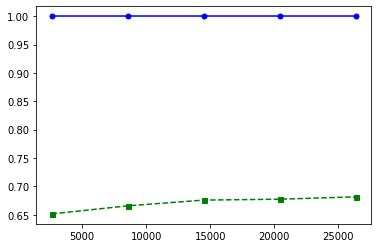

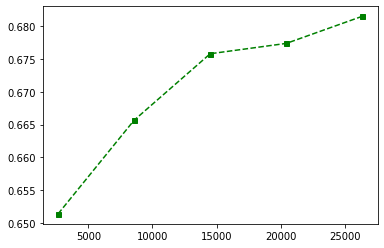

In [30]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue',
         marker='o', markersize=5, label='Training F1')
plt.fill_between(train_sizes, train_mean + train_std,
                 train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s',
         markersize=5, label='Validation F1')
plt.show()

#
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s',
         markersize=5, label='Validation F1')
plt.show()

### plot AUC from the two cross validations

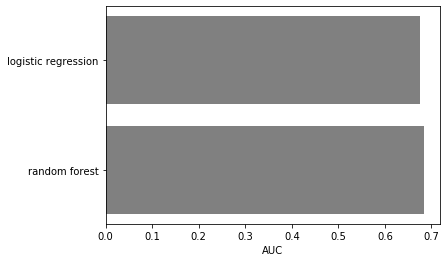

In [31]:
mods = ['logistic regression',
       'random forest']
performance = [log_perf_cv['auc'],
               rf_perf_cv['auc']]
fig, ax = plt.subplots()
y_pos = np.arange(len(mods))
ax.barh(y_pos, performance, align='center', color='grey')
ax.set_yticks(y_pos)
ax.set_yticklabels(mods)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('AUC')
plt.show()
auc_df = pd.DataFrame({'model':mods, 'auc':performance})
auc_df.to_csv('../data/for_plotting/auc_comparison.csv', index=False)

### performance on test set

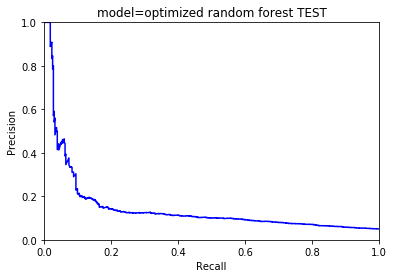

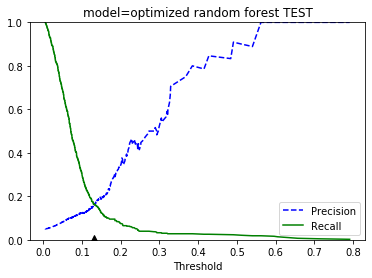

Confusion matrix for threshold = 0.13:
[[8001  360]
 [ 361   70]]
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      8361
           1       0.16      0.16      0.16       431

    accuracy                           0.92      8792
   macro avg       0.56      0.56      0.56      8792
weighted avg       0.92      0.92      0.92      8792



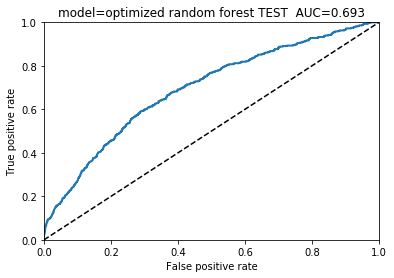

Confusion matrix for threshold = 0.3:
[[8349   12]
 [ 417   14]]
Classification report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      8361
           1       0.54      0.03      0.06       431

    accuracy                           0.95      8792
   macro avg       0.75      0.52      0.52      8792
weighted avg       0.93      0.95      0.93      8792



['../data/for_app/performance.joblib']

In [32]:
#predict for test set
exec(open("my_functions.py").read())
test_scores = rf_opt.predict_proba(X_test)[:, 1]
test_perf = get_model_performance('optimized random forest TEST', X_test, test_scores, y_test, pos_label=1)


threshold = 0.3
opt_pred = (test_scores > threshold).astype('int')
y_num = (y_test==1).astype('int')
print('Confusion matrix for threshold = {}:'.format(round(threshold, 2)))
cm = confusion_matrix(y_num, opt_pred)
print(cm)
print('Classification report:')
print(classification_report(y_num, opt_pred))
joblib.dump(test_perf, '../data/for_app/performance.joblib')

In [33]:
perf_out = pd.DataFrame({'fpr':test_perf['fpr'],
                       'tpr': test_perf['tpr'],
                       'auc' : test_perf['auc']})
perf_out.to_csv('../data/for_plotting/auc_curve.csv', index=False)

### get importance

In [34]:
importances = rf_opt.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_opt.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
features = X_test.columns[indices]
idat = pd.DataFrame({'feature':features,
                     'importance': importances,
                   'std': std,
                   'index':indices})
idat = idat.sort_values('importance', ascending=False)
print(idat.shape)
idat

(294, 4)


,feature,importance,std,index
0,age,0.030430,0.005025,0
1,icu_duration,0.028062,0.004997,1
233,drug_Phenylephrine,0.023563,0.004285,201
94,drug_Metoprolol Tartrate,0.021439,0.003942,182
106,drug_Oxycodone-Acetaminophen,0.015156,0.003181,198
...,...,...,...,...
74,drug_Albuterol 0.083% Neb Soln,0.001468,0.001163,114
54,drug_Potassium Chloride,0.001467,0.000994,207
83,diagnosis_icd9_41401,0.001384,0.000993,42
25,DNword_warfarin,0.001237,0.000959,272


### add back in the human readable names for features

#### diagnoses

In [35]:
# upload the diagnoses table with full names for diagnosis variables
query = query_schema + \
    """select 
    *
    from D_ICD_DIAGNOSES"""
ddat = pd.read_sql_query(query, con)
ddat['feature'] = ['diagnosis_icd9_' + x for x in ddat['icd9_code']]

# merge the importance data with diagnoses table
idat_out = pd.merge(idat, ddat, how='left', on='feature')
to_change = idat_out['short_title'].notna()
idat_out.loc[to_change, 'feature'] = \
    'diagnosis: ' + idat_out['short_title']
idat_out

,feature,importance,std,index,row_id,icd9_code,short_title,long_title
0,age,0.030430,0.005025,0,NaN,NaN,NaN,NaN
1,icu_duration,0.028062,0.004997,1,NaN,NaN,NaN,NaN
2,drug_Phenylephrine,0.023563,0.004285,201,NaN,NaN,NaN,NaN
3,drug_Metoprolol Tartrate,0.021439,0.003942,182,NaN,NaN,NaN,NaN
4,drug_Oxycodone-Acetaminophen,0.015156,0.003181,198,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
289,drug_Albuterol 0.083% Neb Soln,0.001468,0.001163,114,NaN,NaN,NaN,NaN
290,drug_Potassium Chloride,0.001467,0.000994,207,NaN,NaN,NaN,NaN
291,diagnosis: Crnry athrscl natve vssl,0.001384,0.000993,42,4374.0,41401,Crnry athrscl natve vssl,Coronary atherosclerosis of native coronary ar...
292,DNword_warfarin,0.001237,0.000959,272,NaN,NaN,NaN,NaN


#### procedures

In [36]:
# upload the procedure table with full names for procedures
query = query_schema + \
    """select 
    *
    from D_ICD_PROCEDURES"""
ddat = pd.read_sql_query(query, con)
ddat['feature'] = ['procedure_icd9_' + x for x in ddat['icd9_code']]

# merge the importance data with diagnoses table
idat_out = idat_out.loc[:, idat.columns]
idat_out = pd.merge(idat_out, ddat, how='left', on='feature')
to_change = (idat_out['short_title'].notna())
idat_out.loc[to_change, 'feature'] = \
    'procedure: ' + idat_out['short_title']
idat_out

,feature,importance,std,index,row_id,icd9_code,short_title,long_title
0,age,0.030430,0.005025,0,NaN,NaN,NaN,NaN
1,icu_duration,0.028062,0.004997,1,NaN,NaN,NaN,NaN
2,drug_Phenylephrine,0.023563,0.004285,201,NaN,NaN,NaN,NaN
3,drug_Metoprolol Tartrate,0.021439,0.003942,182,NaN,NaN,NaN,NaN
4,drug_Oxycodone-Acetaminophen,0.015156,0.003181,198,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
289,drug_Albuterol 0.083% Neb Soln,0.001468,0.001163,114,NaN,NaN,NaN,NaN
290,drug_Potassium Chloride,0.001467,0.000994,207,NaN,NaN,NaN,NaN
291,diagnosis: Crnry athrscl natve vssl,0.001384,0.000993,42,NaN,NaN,NaN,NaN
292,DNword_warfarin,0.001237,0.000959,272,NaN,NaN,NaN,NaN


#### change prefixes

In [37]:
#drug prefix from drug_ to drug: 
to_change = idat_out['feature'].str.startswith('drug_')
idat_out['feature'] = idat_out['feature'].str.replace('drug_', 'drug: ')
idat_out

#religion prefix from religion_ to religion: 
to_change = idat_out['feature'].str.startswith('drug_')
idat_out['feature'] = idat_out['feature'].str.replace('religion_', 'religion: ')
idat_out

,feature,importance,std,index,row_id,icd9_code,short_title,long_title
0,age,0.030430,0.005025,0,NaN,NaN,NaN,NaN
1,icu_duration,0.028062,0.004997,1,NaN,NaN,NaN,NaN
2,drug: Phenylephrine,0.023563,0.004285,201,NaN,NaN,NaN,NaN
3,drug: Metoprolol Tartrate,0.021439,0.003942,182,NaN,NaN,NaN,NaN
4,drug: Oxycodone-Acetaminophen,0.015156,0.003181,198,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
289,drug: Albuterol 0.083% Neb Soln,0.001468,0.001163,114,NaN,NaN,NaN,NaN
290,drug: Potassium Chloride,0.001467,0.000994,207,NaN,NaN,NaN,NaN
291,diagnosis: Crnry athrscl natve vssl,0.001384,0.000993,42,NaN,NaN,NaN,NaN
292,DNword_warfarin,0.001237,0.000959,272,NaN,NaN,NaN,NaN


### save for app

In [38]:
import joblib
joblib.dump(idat_out.loc[idat_out['importance']>0.0,:], '../data/for_app/importances.joblib');